Please Open this file with and IDE that supports jupyter notebooks in our desired format. You should be able to see the graphs already generated.



*   Example of an IDE that supports this file : Visual Studio Code
*   Example of an IDE that DOESNT support this file in the desired format : Pycharm



# Setting up

In [ ]:
!pip install GitPython pandas > /dev/null 2>&1
!pip install pydriller pandas matplotlib > /dev/null 2>&1
!pip install nltk > /dev/null 2>&1
!pip install spacy > /dev/null 2>&1
!python -m spacy download en_core_web_sm > /dev/null 2>&1
!pip install emoji > /dev/null 2>&1
!pip install regex > /dev/null 2>&1

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt

Extracting commits using their URL

In [ ]:
def getCommits(repo_url):
  commit_data = {
      'CommitSHA': [],
      'Date': [],
      'Message': [],
  }

  for commit in Repository(repo_url).traverse_commits():
      commit_data['CommitSHA'].append(commit.hash)
      commit_data['Date'].append(commit.committer_date)
      commit_data['Message'].append(commit.msg)
  commit_df = pd.DataFrame(commit_data)
  return commit_df

Plotting commits with conventional commits

In [ ]:
def plotCommits(commit_df, name):
  commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)
  conventional_commit_pattern = r'^(feat|feature|fix|chore|docs|doc|style|refactor|perf|test|design|build|cleanup|FEAT|FEATURE|FIX|CHORE|DOCS|DOC|STYLE|REFACTOR|PERF|TEST|DESIGN|BUILD|CLEANUP|Feat|Feature|Fix|Chore|Docs|Doc|Style|Refactor|Perf|Test|Design|Build|Cleanup)(?:\s*(?:\(.+\)|\[[^\]]+\]))?(\s+:\s+.+)?'

  unicode_emoji_pattern = r'[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
  colon_emoji_pattern = r':(?:[a-z0-9_]+):'
  combined_emoji_pattern = f'(?:{unicode_emoji_pattern}|{colon_emoji_pattern})'

  commit_df['Conventional'] = commit_df['Message'].str.match(conventional_commit_pattern)
  commit_df['Gitmoji'] = commit_df['Message'].str.contains(combined_emoji_pattern)
  commit_df['NonConventional'] = ~(commit_df['Conventional'] | commit_df['Gitmoji'])

  commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[['Conventional', 'Gitmoji', 'NonConventional']].sum()

  commit_counts_by_year.plot(kind='bar', stacked=True)
  plt.xlabel('Year')
  plt.ylabel('Commit Count')
  plt.title('Changes in Commit Types Over Time - '+ name)
  plt.legend(['Conventional', 'Gitmoji', 'Non-Conventional'])
  plt.show()

In [ ]:
# keeping original pattern : conventional_commit_pattern = r'^(feat|feature|fix|chore|docs|doc|style|refactor|perf|test|design|build|cleanup|FEAT|FEATURE|FIX|CHORE|DOCS|DOC|STYLE|REFACTOR|PERF|TEST|DESIGN|BUILD|CLEANUP|Feat|Feature|Fix|Chore|Docs|Doc|Style|Refactor|Perf|Test|Design|Build|Cleanup)(\(.+\))?(\s*\(.+\))?: .+'


function to save the non conventional commits to analyze the false positives and to be able to study if there is any commonly used subsystem that could be included in our functions

In [ ]:
def saveNonConventional(commit_df, name):
  non_conventional_commits = commit_df[commit_df['NonConventional']]

  non_conventional_messages = non_conventional_commits['Message'].tolist()
  with open('non_conventional_commits_'+name+'.txt', 'w') as file:
      for message in non_conventional_messages:
          file.write("COMMIT MESSAGE :")
          file.write(message + '\n')

Function to extract the convention of "first word must be a verb". This convention has been defined in many repositories, notably Django.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def is_first_word_verb(text):
    if not text.strip():
        return False

    if len(text) > nlp.max_length:
        return False

    doc = nlp(text)
    if not doc:
        return False

    first_token = doc[0]
    return first_token.pos_ == 'VERB'


test_sentence = "Work on website styling."
print(is_first_word_verb(test_sentence))


True


Function to plot conventional commits AND a verb start convention

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plotNewCommits(commit_df, name):
    commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)

    unicode_emoji_pattern = r'[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
    colon_emoji_pattern = r':(?:[a-z0-9_]+):'
    combined_emoji_pattern = f'(?:{unicode_emoji_pattern}|{colon_emoji_pattern})'

    conventional_commit_pattern = r'^(feat|feature|fix|chore|docs|doc|style|refactor|perf|test|design|build|cleanup|FEAT|FEATURE|FIX|CHORE|DOCS|DOC|STYLE|REFACTOR|PERF|TEST|DESIGN|BUILD|CLEANUP|Feat|Feature|Fix|Chore|Docs|Doc|Style|Refactor|Perf|Test|Design|Build|Cleanup)(?:\s*(?:\(.+\)|\[[^\]]+\]))?(\s+:\s+.+)?'

    commit_df['Conventional'] = commit_df['Message'].apply(lambda x: bool(re.match(conventional_commit_pattern, x)) or is_first_word_verb(x))
    commit_df['Gitmoji'] = commit_df['Message'].str.contains(combined_emoji_pattern)
    commit_df['NonConventional'] = ~(commit_df['Gitmoji'] | commit_df['Conventional'])

    commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[['Conventional', 'Gitmoji', 'NonConventional']].sum()

    commit_counts_by_year.plot(kind='bar', stacked=True)
    plt.xlabel('Year')
    plt.ylabel('Commit Count')
    plt.title('Commit Types Over Time - ' + name)
    plt.legend(['Conventional', 'Gitmoji', 'Non-Conventional'])
    plt.show()

    non_conventional_commits = commit_df[commit_df['NonConventional']]

    non_conventional_messages = non_conventional_commits['Message'].tolist()
    with open('v2_non_conventional_commits_'+name+'.txt', 'w') as file:
        for message in non_conventional_messages:
            file.write("COMMIT MESSAGE :")
            file.write(message + '\n')


**Example of how this tool gets modified to study and plot graphs for graphs :** Function Specifically made for node after finding their defined subsystems in their commit validator system

In [ ]:
def plotNodeCommits(commit_df, name):
  commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)

  validSubsystems = [
      "benchmark", "build", "bootstrap", "cli", "deps", "doc", "errors", "etw",
      "esm", "gyp", "inspector", "lib", "loader", "meta", "msi", "node", "node-api",
      "perfctr", "permission", "policy", "sea", "src", "test", "tools", "typings",
      "wasm", "watch", "win", "assert", "async_hooks", "buffer", "child_process",
      "cluster", "console", "constants", "crypto", "debugger", "diagnostics_channel",
      "dgram", "dns", "domain", "events", "fs", "http", "http2", "https", "inspector",
      "module", "net", "os", "path", "perf_hooks", "process", "punycode", "querystring",
      "quic", "readline", "repl", "report", "stream", "string_decoder", "sys",
      "test_runner", "timers", "tls", "trace_events", "tty", "url", "util", "v8",
      "vm", "wasi", "worker", "zlib"
  ]

  subsystems_pattern = '|'.join(validSubsystems)
  conventional_commit_pattern = rf'^({subsystems_pattern}): .+'

  unicode_emoji_pattern = r'[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
  colon_emoji_pattern = r':(?:[a-z0-9_]+):'
  combined_emoji_pattern = f'(?:{unicode_emoji_pattern}|{colon_emoji_pattern})'

  commit_df['Conventional'] = commit_df['Message'].str.match(conventional_commit_pattern)
  commit_df['Gitmoji'] = commit_df['Message'].str.contains(combined_emoji_pattern)
  commit_df['NonConventional'] = ~(commit_df['Conventional'] | commit_df['Gitmoji'])

  commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[['Conventional', 'Gitmoji', 'NonConventional']].sum()

  commit_counts_by_year.plot(kind='bar', stacked=True)
  plt.xlabel('Year')
  plt.ylabel('Commit Count')
  plt.title('Changes in Commit Types Over Time - '+ name)
  plt.legend(['Conventional', 'Gitmoji', 'Non-Conventional'])
  plt.show()

# Node js

Plotting with typical conventional commits

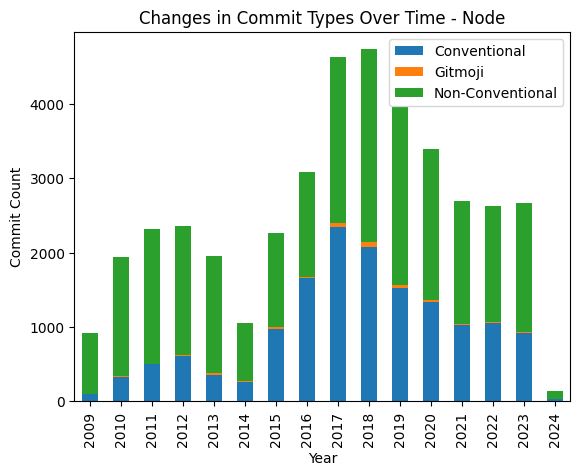

In [ ]:
repo_url = 'https://github.com/nodejs/node.git'
name = 'Node'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)

Plotting with the conventions node defined

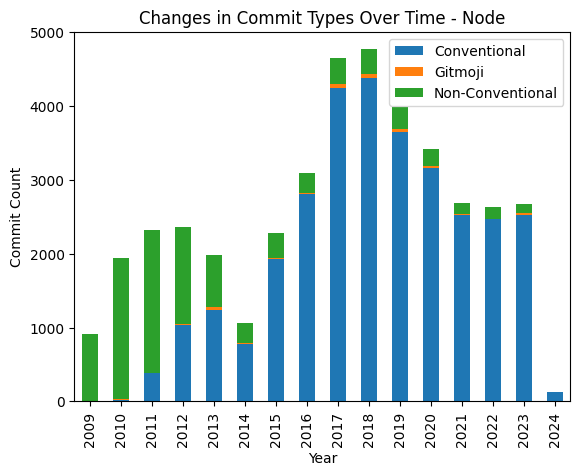

In [ ]:
newCommit_df = plotNodeCommits(commit_df, name)

# Angular

Angular defined the norm for conventional commits

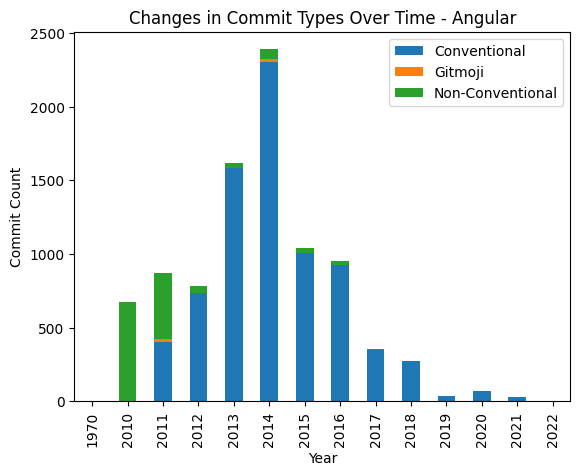

In [ ]:
repo_url = 'https://github.com/angular/angular.js'
name = 'Angular'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)


# FastAPI

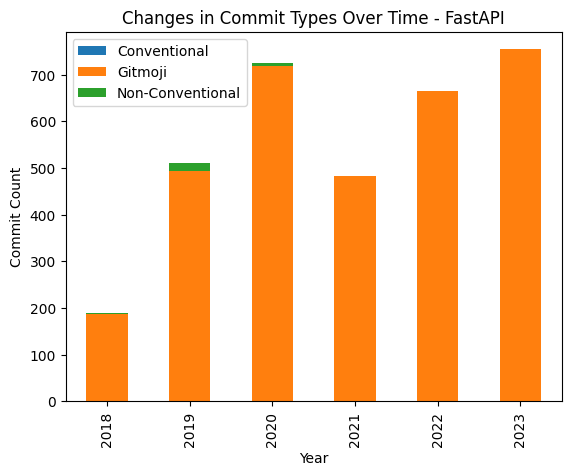

In [ ]:
repo_url = 'https://github.com/tiangolo/fastapi'
name = 'FastAPI'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)

# Gitmoji

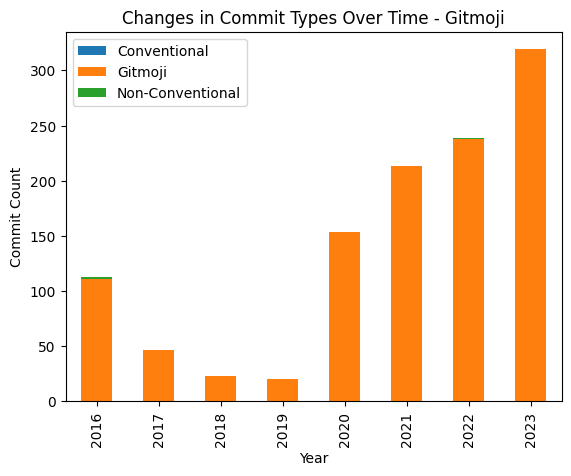

In [ ]:
repo_url = 'https://github.com/carloscuesta/gitmoji'
name = 'Gitmoji'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)

# Flutter

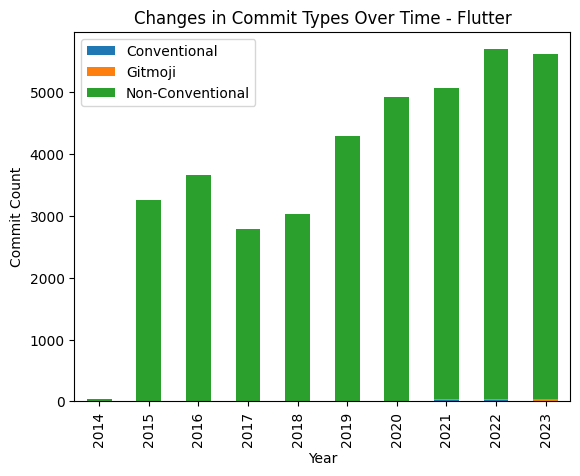

In [ ]:
repo_url = 'https://github.com/flutter/flutter'
name = 'Flutter'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)

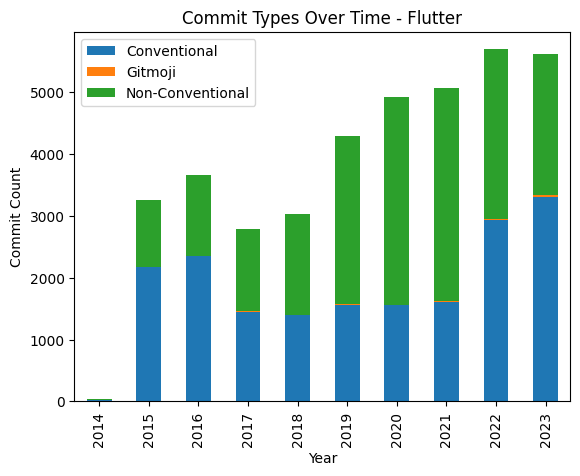

In [ ]:
newCommit_df = plotNewCommits(commit_df, name)

# Django

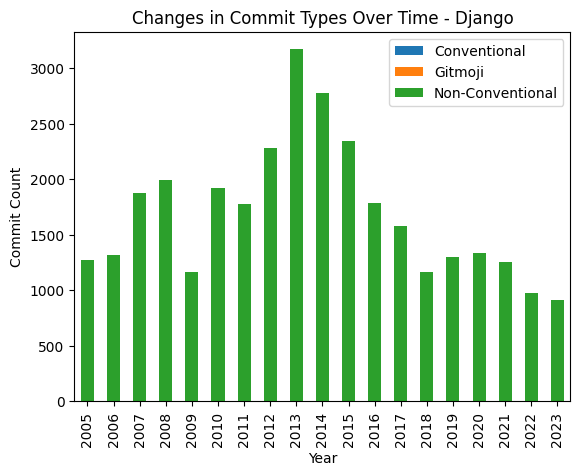

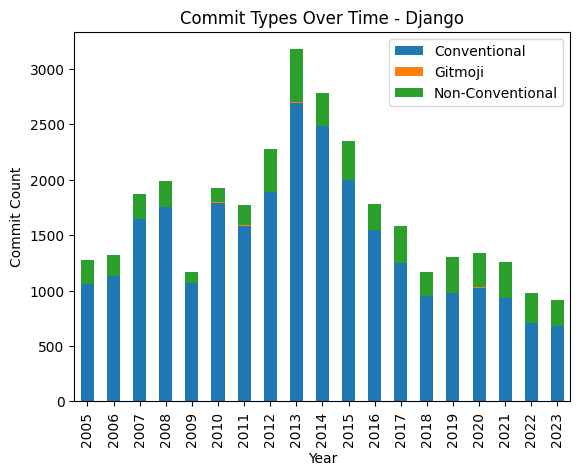

In [ ]:
repo_url = 'https://github.com/django/django'
name = 'Django'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)
newCommit_df = plotNewCommits(commit_df, name)

# Cpython

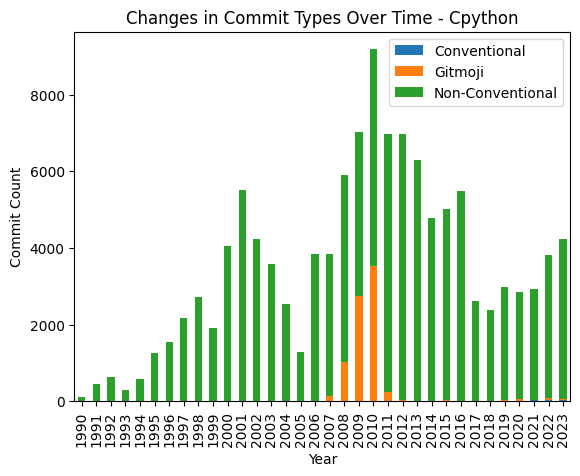

In [ ]:
repo_url = 'https://github.com/python/cpython'
name = 'Cpython'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)

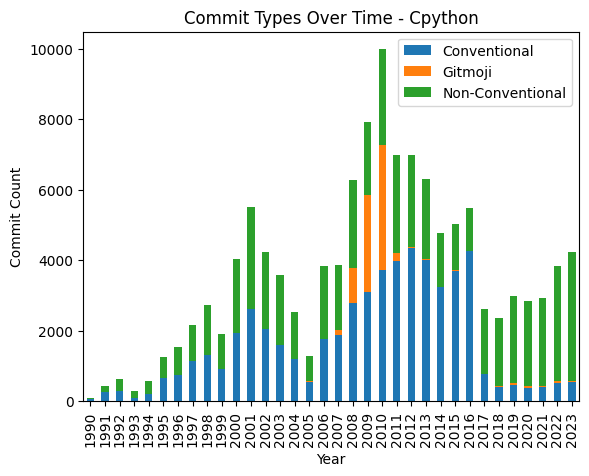

In [ ]:
newCommit_df = plotNewCommits(commit_df, name)

# TypeScript

But, of course, our tool doesn't work perfectly since in conventions are hard to figure out sometimes especially when they're not public

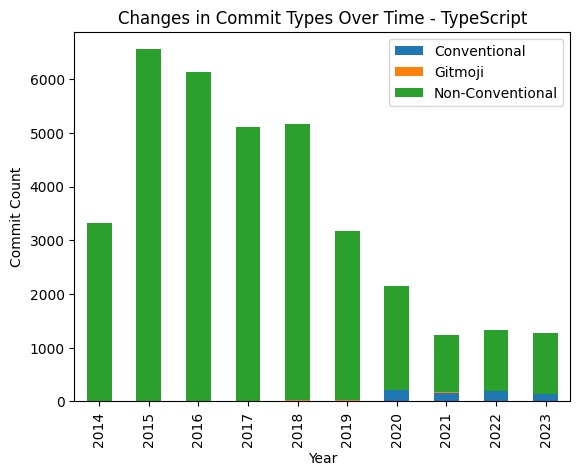

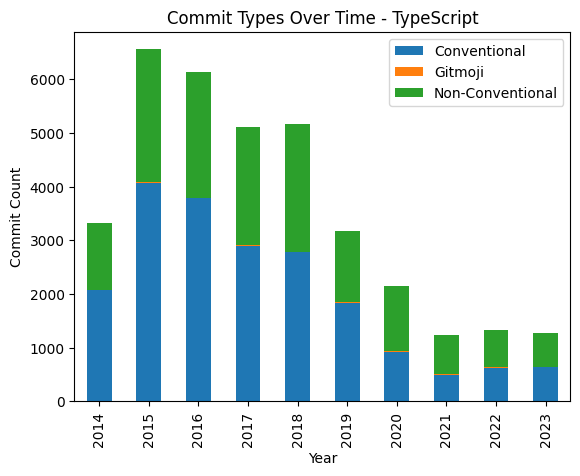

In [ ]:
repo_url = 'https://github.com/microsoft/TypeScript'
name = 'TypeScript'
commit_df = getCommits(repo_url)
plotCommits(commit_df, name)
saveNonConventional(commit_df, name)
newCommit_df = plotNewCommits(commit_df, name)


# Analyzing projects from the same companies


## **Apache :**


*   KAFKA

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def kafkaCommits(commit_df, name):
    commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)

    conventional_pattern = r'^(KAFKA-\d+.*|MINOR:|HOTFIX:).*'
    wip_pattern = r'\[WIP\]'

    commit_df['Conventional'] = commit_df['Message'].str.contains(conventional_pattern) & ~commit_df['Message'].str.contains(wip_pattern)
    commit_df['NonConventional'] = ~commit_df['Conventional']

    categories = ['Conventional', 'NonConventional']
    commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[categories].sum()
    commit_counts_by_year.plot(kind='bar', stacked=True)
    plt.xlabel('Year')
    plt.ylabel('Commit Count')
    plt.title(f'Commit Types Over Time - {name}')
    plt.legend(categories)
    plt.show()

    non_conventional_commits = commit_df[commit_df['NonConventional']]
    non_conventional_messages = non_conventional_commits['Message'].tolist()
    with open(f'kafka_non_conventional_commits_{name}.txt', 'w') as file:
        for message in non_conventional_messages:
            file.write("COMMIT MESSAGE: ")
            file.write(message + '\n')

<ipython-input-8-d79d770318e8>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  commit_df['Conventional'] = commit_df['Message'].str.contains(conventional_pattern) & ~commit_df['Message'].str.contains(wip_pattern)


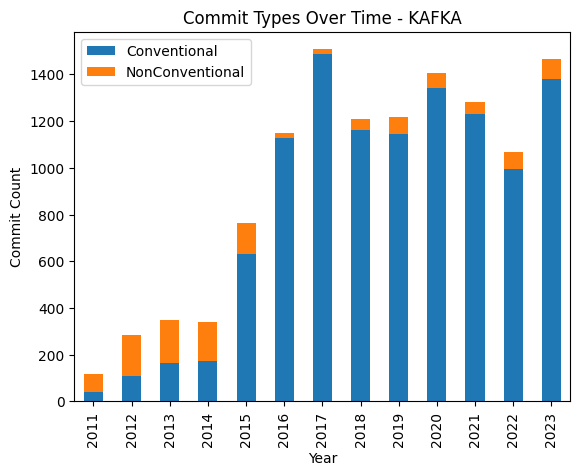

In [ ]:
repo_url = 'https://github.com/apache/kafka'
name = 'KAFKA'
commit_df = getCommits(repo_url)
kafkaCommits(commit_df, name)

*   SPARK

In [ ]:
def sparkCommits(commit_df, name):
    commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)

    spark_commit_pattern = r'\[SPARK-\d+\]\[.*\].*'
    wip_pattern = r'\[WIP\]'

    commit_df['Conventional'] = commit_df['Message'].str.contains(spark_commit_pattern) & ~commit_df['Message'].str.contains(wip_pattern)
    commit_df['NonConventional'] = ~commit_df['Conventional']

    categories = ['Conventional', 'NonConventional']
    commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[categories].sum()
    commit_counts_by_year.plot(kind='bar', stacked=True)
    plt.xlabel('Year')
    plt.ylabel('Commit Count')
    plt.title(f'Commit Types Over Time - {name}')
    plt.legend(categories)
    plt.show()

    non_conventional_commits = commit_df[commit_df['NonConventional']]
    non_conventional_messages = non_conventional_commits['Message'].tolist()
    with open(f'spark_non_conventional_commits_{name}.txt', 'w') as file:
        for message in non_conventional_messages:
            file.write("COMMIT MESSAGE: ")
            file.write(message + '\n')

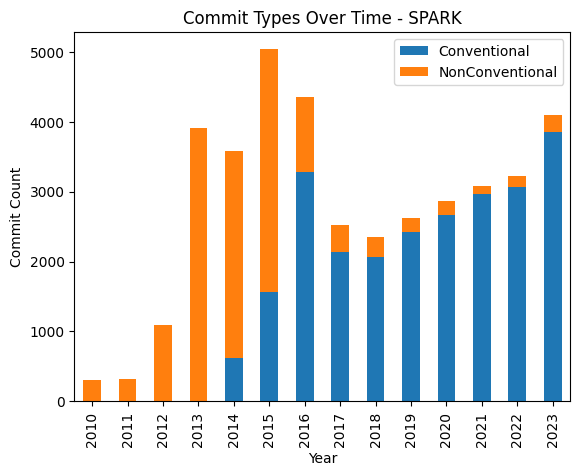

In [ ]:
repo_url = 'https://github.com/apache/spark'
name = 'SPARK'
commit_df = getCommits(repo_url)
sparkCommits(commit_df, name)

## **Meta :**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def metaCommits(commit_df, name):
    commit_df['Date'] = pd.to_datetime(commit_df['Date'], utc=True)

    unicode_emoji_pattern = r'[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+'
    colon_emoji_pattern = r':(?:[a-z0-9_]+):'
    combined_emoji_pattern = f'(?:{unicode_emoji_pattern}|{colon_emoji_pattern})'
    conventional_commit_pattern = r'^(Event API|Event API|Flare|nit|DevTools|Bugfix|Revert|Bug|Scheduling Profiler|Offscreen|Fizz|CI|Flow|feat|feature|fix|chore|docs|doc|style|refactor|perf|test|design|build|cleanup|FEAT|FEATURE|FIX|CHORE|DOCS|DOC|STYLE|REFACTOR|PERF|TEST|DESIGN|BUILD|CLEANUP|Feat|Feature|Fix|Chore|Docs|Doc|Style|Refactor|Perf|Test|Design|Build|Cleanup)(?:\s*(?:\(.+\)|\[[^\]]+\]))?(\s+:\s+.+)?'
    bracket_commit_pattern = r'^\[[^\]]+\].*'

    commit_df['ConventionalNorm'] = commit_df['Message'].apply(lambda x: bool(re.match(conventional_commit_pattern, x)))
    commit_df['ConventionalVerb'] = commit_df['Message'].apply(is_first_word_verb)
    commit_df['ConventionalBrackets'] = commit_df['Message'].str.contains(bracket_commit_pattern)
    commit_df['Gitmoji'] = commit_df['Message'].str.contains(combined_emoji_pattern)
    commit_df['Conventional'] = commit_df['ConventionalNorm'] | commit_df['ConventionalVerb'] | commit_df['ConventionalBrackets']
    commit_df['NonConventional'] = ~(commit_df['Conventional'] | commit_df['Gitmoji'])

    categories = ['Conventional', 'Gitmoji', 'NonConventional']
    commit_counts_by_year = commit_df.groupby(commit_df['Date'].dt.year)[categories].sum()
    commit_counts_by_year.plot(kind='bar', stacked=True)
    plt.xlabel('Year')
    plt.ylabel('Commit Count')
    plt.title(f'Commit Types Over Time - {name}')
    plt.legend(categories)
    plt.show()

    non_conventional_commits = commit_df[commit_df['NonConventional']]
    non_conventional_messages = non_conventional_commits['Message'].tolist()
    with open(f'v2_non_conventional_commits_{name}.txt', 'w') as file:
        for message in non_conventional_messages:
            file.write("COMMIT MESSAGE: ")
            file.write(message + '\n')



*   **React**



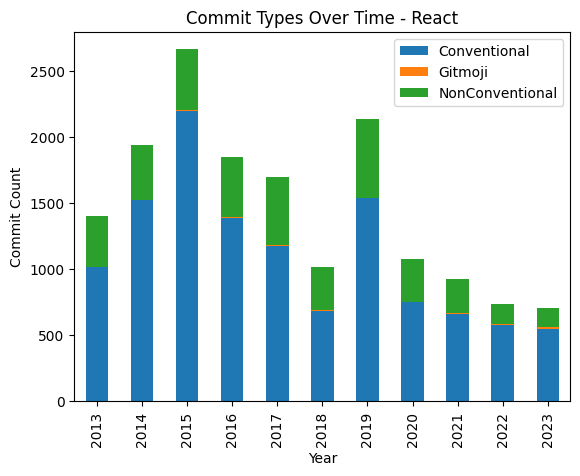

In [ ]:
repo_url = 'https://github.com/facebook/react'
name = 'React'
commit_df = getCommits(repo_url)
metaCommits(commit_df, name)

*   **React Native**



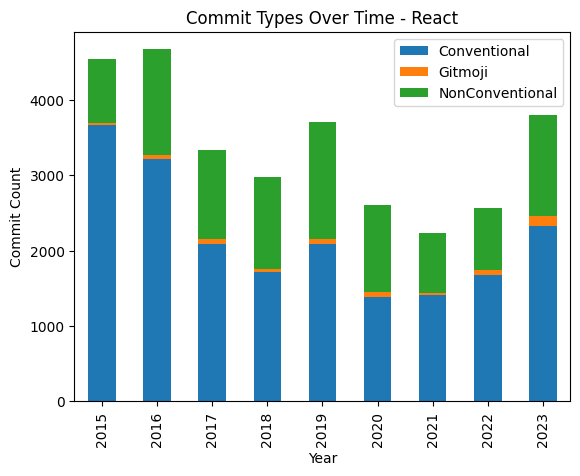

In [ ]:
repo_url = 'https://github.com/facebook/react-native'
name = 'React Native'
commit_df = getCommits(repo_url)
metaCommits(commit_df, name)



*   **Lexical**


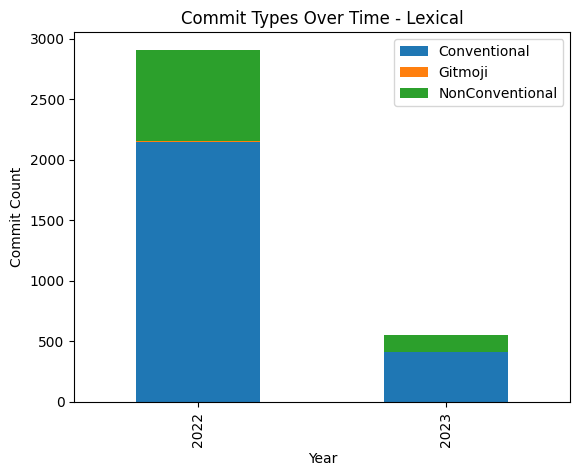

In [ ]:
repo_url = 'https://github.com/facebook/lexical'
name = 'Lexical'
commit_df = getCommits(repo_url)
metaCommits(commit_df, name)

# Testing Tool Accuracy

In [ ]:
!pip install odfpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=cd1a295dc2cc08fc5e2c3f1574e23db0a87cab955659892840018dfa3c25ce0e
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy


In [ ]:
import pandas as pd
import re

def evaluate_commit_accuracy(file_path):
    df = pd.read_excel(file_path, sheet_name=1)

    conventional_commit_pattern = r'^(feat|feature|fix|chore|docs|doc|style|refactor|perf|test|design|build|cleanup|FEAT|FEATURE|FIX|CHORE|DOCS|DOC|STYLE|REFACTOR|PERF|TEST|DESIGN|BUILD|CLEANUP|Feat|Feature|Fix|Chore|Docs|Doc|Style|Refactor|Perf|Test|Design|Build|Cleanup)(\(.+\))?(\s*\(.+\))?: .+'

    TP = FP = TN = FN = 0

    for index, row in df.iterrows():
        commit_message = row['commits']
        actual_type = row['type']

        is_conventional = re.match(conventional_commit_pattern, commit_message) is not None

        if is_conventional and actual_type == 1:
            TP += 1
        elif is_conventional and actual_type == 0:
            FP += 1
        elif not is_conventional and actual_type == 0:
            TN += 1
        elif not is_conventional and actual_type == 1:
            FN += 1
    total = TP + FP + TN + FN
    accuracy = ((TP + TN) / total) * 100 if total > 0 else 0

    return {
        "True Positives (TP)": TP,
        "False Positives (FP)": FP,
        "True Negatives (TN)": TN,
        "False Negatives (FN)": FN,
        "Accuracy (%)": accuracy
    }

file_path = "/content/Conventionnal_commit_mlanual.ods"
result = evaluate_commit_accuracy(file_path)
print(result)



{'True Positives (TP)': 65, 'False Positives (FP)': 2, 'True Negatives (TN)': 261, 'False Negatives (FN)': 2, 'Accuracy (%)': 98.7878787878788}
